# Anomaly Detection in Time Series

Поиск аномалий во временных рядах на основе аппроксимации нормального поведения сигнала 
и анализа отклонений (residual-based approach).


## Project Description

В данном проекте рассматривается задача поиска аномалий во временных рядах, 
имитирующих технические данные (датчики, серверные метрики, сетевые показатели).

Цель — выявить редкие отклонения от нормального поведения сигнала 
без использования обучающей разметки (unsupervised / semi-supervised подход).


In [12]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

np.random.seed(42)

# параметры временного ряда
n_points = 1000
time = np.arange(n_points)

# нормальный сигнал
signal = (
    np.sin(2 * np.pi * time / 50) +
    np.random.normal(0, 0.2, n_points)
)

# создаем датафрейм
df = pd.DataFrame({
    "time": time,
    "value": signal,
    "is_anomaly": 0
})

# добавляем аномалии
n_anomalies = int(0.03 * n_points)
anomaly_indices = np.random.choice(n_points, n_anomalies, replace=False)

df.loc[anomaly_indices, "value"] += np.random.normal(
    loc=3.0, scale=0.5, size=n_anomalies
)
df.loc[anomaly_indices, "is_anomaly"] = 1

df.head()


,time,value,is_anomaly
0,0,0.099343,0
1,1,0.097680,0
2,2,0.378228,0
3,3,0.672731,0
4,4,0.434923,0


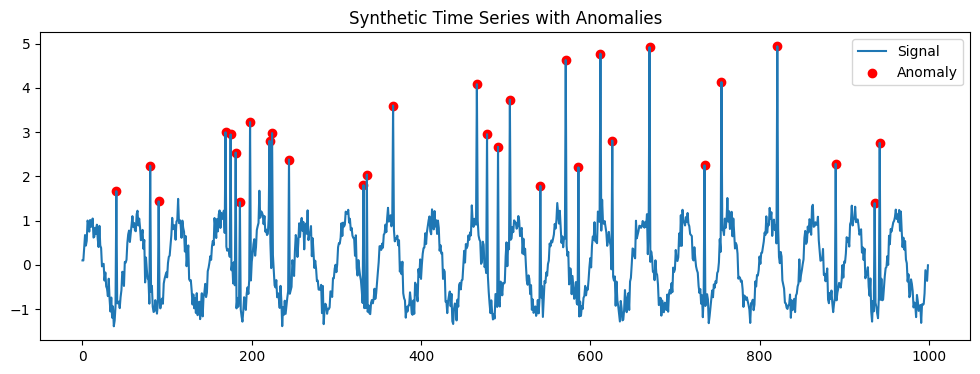

In [13]:
plt.figure(figsize=(12, 4))
plt.plot(df["time"], df["value"], label="Signal")
plt.scatter(
    df[df["is_anomaly"] == 1]["time"],
    df[df["is_anomaly"] == 1]["value"],
    color="red",
    label="Anomaly"
)
plt.legend()
plt.title("Synthetic Time Series with Anomalies")
plt.show()


## Data

Используются синтетически сгенерированные временные ряды, включающие:
- периодический сигнал (нормальное поведение системы)
- случайный шум
- редкие аномалии в виде резких выбросов

Синтетические данные позволяют полностью контролировать свойства сигнала 
и использовать разметку для последующей оценки качества алгоритмов.



## Exploratory Data Analysis (EDA)

Временной ряд представляет собой квазипериодический сигнал с устойчивым базовым уровнем и умеренным уровнем шума. В отдельных точках наблюдаются резкие кратковременные выбросы, значительно отклоняющиеся от локального поведения сигнала и интерпретируемые как аномалии. Распределение значений асимметрично за счёт редких экстремальных наблюдений, при этом основная масса данных сосредоточена в узком диапазоне вокруг среднего значения.


## Feature Engineering

Для аппроксимации нормального поведения сигнала используются локальные статистики:
- скользящее среднее (rolling mean)
- скользящее стандартное отклонение (rolling std)

Дополнительно рассчитывается остаток (residual) как разница между фактическим значением 
и локальной аппроксимацией сигнала.


In [4]:
df["rolling_mean"] = df["value"].rolling(window=25, center=True).mean()
df["rolling_std"] = df["value"].rolling(window=25, center=True).std()
df[100: 110]

,time,value,is_anomaly,rolling_mean,rolling_std
100,100,-0.283074,0,0.063504,0.772480
101,101,0.041204,0,0.167290,0.783313
102,102,0.180147,0,0.240228,0.766482
103,103,0.207669,0,0.223342,0.743400
104,104,0.449497,0,0.287701,0.728633
105,105,0.668595,0,0.351514,0.680842
106,106,1.061784,0,0.424919,0.645479
107,107,0.805429,0,0.488835,0.600497
108,108,0.895838,0,0.553894,0.529921
109,109,0.889938,0,0.582791,0.492859


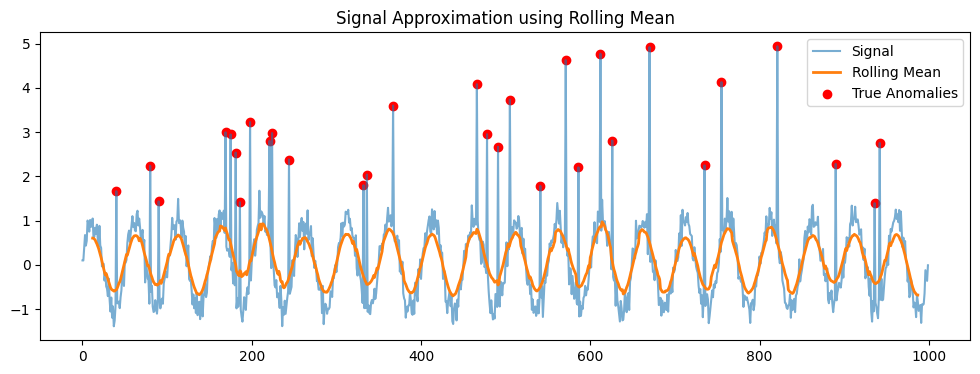

In [5]:
plt.figure(figsize=(12, 4))
plt.plot(df["time"], df["value"], label="Signal", alpha=0.6)
plt.plot(df["time"], df["rolling_mean"], label="Rolling Mean", linewidth=2)

plt.scatter(
    df[df["is_anomaly"] == 1]["time"],
    df[df["is_anomaly"] == 1]["value"],
    color="red",
    label="True Anomalies"
)

plt.legend()
plt.title("Signal Approximation using Rolling Mean")
plt.show()


In [6]:
window = 25  # размер окна, будем подбирать

df["rolling_mean"] = (
    df["value"]
    .rolling(window=window, center=True)
    .mean()
)

df["rolling_std"] = (
    df["value"]
    .rolling(window=window, center=True)
    .std()
)


In [ ]:
# df = df.dropna().reset_index(drop=True)

## Anomaly Detection Method

Аномалии выявляются на основе анализа остатков:
наблюдение считается аномальным, если абсолютное значение остатка 
превышает порог, масштабированный на локальное стандартное отклонение.

Используемый критерий:
|residual| > k · rolling_std

Данный подход адаптируется к изменению уровня шума сигнала 
и имеет статистическую интерпретацию.


In [7]:
df["residual"] = df["value"] - df["rolling_mean"]
df[100:110]

,time,value,is_anomaly,rolling_mean,rolling_std,residual
100,100,-0.283074,0,0.063504,0.772480,-0.346578
101,101,0.041204,0,0.167290,0.783313,-0.126085
102,102,0.180147,0,0.240228,0.766482,-0.060081
103,103,0.207669,0,0.223342,0.743400,-0.015673
104,104,0.449497,0,0.287701,0.728633,0.161796
105,105,0.668595,0,0.351514,0.680842,0.317081
106,106,1.061784,0,0.424919,0.645479,0.636865
107,107,0.805429,0,0.488835,0.600497,0.316594
108,108,0.895838,0,0.553894,0.529921,0.341944
109,109,0.889938,0,0.582791,0.492859,0.307147


In [8]:
k = 3

df["predicted_anomaly"] = (
    df["residual"].abs() > k * df["rolling_std"]
).astype(int)


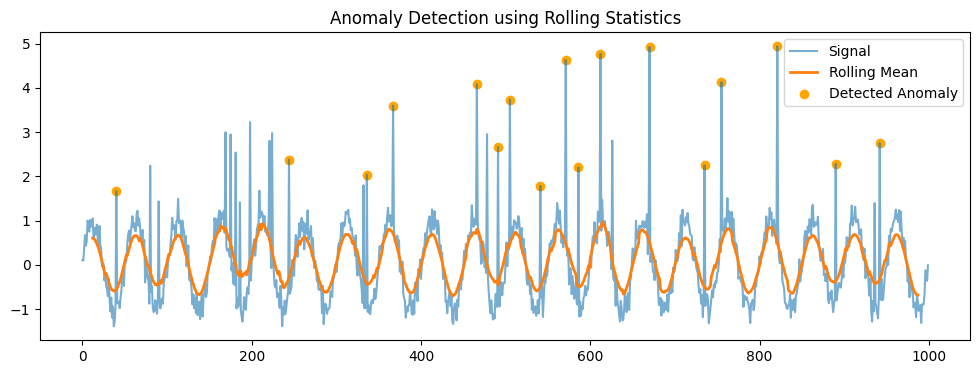

In [9]:
plt.figure(figsize=(12, 4))

plt.plot(df["time"], df["value"], label="Signal", alpha=0.6)
plt.plot(df["time"], df["rolling_mean"], label="Rolling Mean", linewidth=2)

plt.scatter(
    df[df["predicted_anomaly"] == 1]["time"],
    df[df["predicted_anomaly"] == 1]["value"],
    color="orange",
    label="Detected Anomaly"
)

plt.legend()
plt.title("Anomaly Detection using Rolling Statistics")
plt.show()


## Evaluation

Поскольку данные содержат разметку аномалий, 
качество алгоритма оценивается с использованием метрик:
- Precision
- Recall
- F1-score

Также анализируется trade-off между количеством ложных срабатываний 
и пропущенных аномалий при изменении порогового параметра k.


In [11]:
from sklearn.metrics import classification_report

print(
    classification_report(
        df["is_anomaly"],
        df["predicted_anomaly"]
    )
)


              precision    recall  f1-score   support

           0       0.99      1.00      0.99       970
           1       1.00      0.57      0.72        30

    accuracy                           0.99      1000
   macro avg       0.99      0.78      0.86      1000
weighted avg       0.99      0.99      0.99      1000



## Conclusion

В рамках проекта реализован интерпретируемый baseline-алгоритм поиска аномалий 
на основе локальной аппроксимации сигнала и анализа отклонений.

Подход не требует обучающей разметки, адаптируется к локальным изменениям шума 
и может служить отправной точкой для сравнения с ML-моделями 
(Isolation Forest, One-Class SVM, Autoencoder).
